## Домашнее задание №7

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

### Задача №1: 
Обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В данном задании воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку первого занятия.

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на готовые примеры, а не просто "скопировать-вставить". Это поможет вам в дальнейшем.

100%|██████████| 9912422/9912422 [00:16<00:00, 589712.65it/s] 


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 1671229.03it/s]


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw



100%|██████████| 1648877/1648877 [00:01<00:00, 1509018.67it/s]


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 3372968.97it/s]


Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



Text(0.5, 1.0, 'Image label: 6')

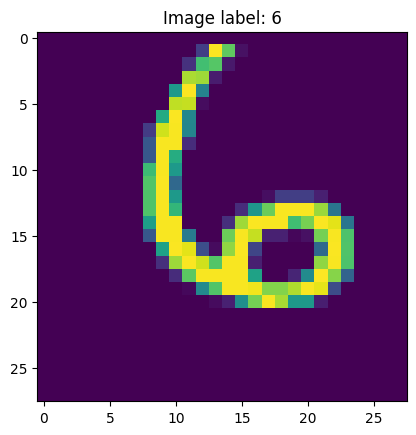

In [2]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 92% accuracy.

*Комментарий: для этого достаточно линейных слоев и функций активации.*

__Внимание, ваша модель должна быть представлена именно переменной `model`.__

In [33]:
# Creating model instance
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.linear1 = nn.Linear(in_features=28 * 28,
                                 out_features=128)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.linear2 = nn.Linear(in_features=128, 
                                 out_features=10)
    def forward(self, x):
        x = self.leaky_relu(self.linear1(x))
        x = self.linear2(x)
        return x
    
model = SimpleModel() # your code here

Локальные тесты для проверки вашей модели доступны ниже:

In [34]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)    
except Exception as e:
    print('Something is wrong with the model')
    raise e
    
    
assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Рекомендуем поработать с различными оптимизаторами.

0.07204058689503309 0.09143813415528583


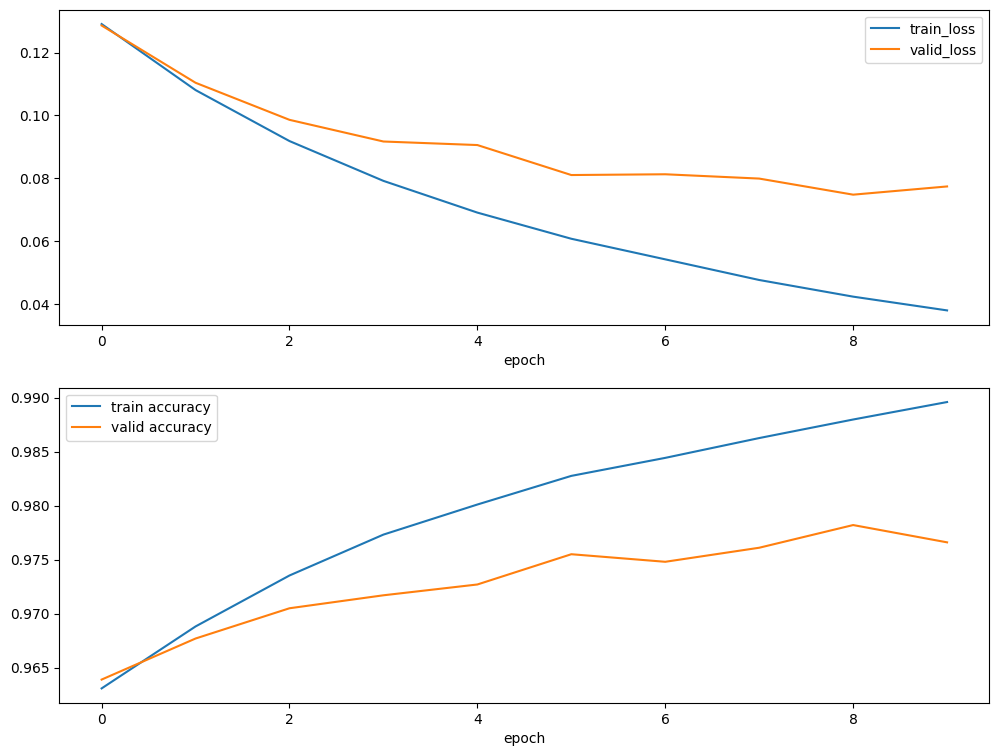

In [36]:
# your code here
def fit(epoches, model, loss_fn, optim, dataset, scheduler=None):
    accuracies: dict = {
            'train': [],
            'valid': []
        }
    losses: dict = {
        'train': [],
        'valid': []
    }
    best_model_weights = model.state_dict()
    best_accuracy: float = 0.
        
    for epoch in range(epoches):
        for phase in phases:
            loss_sum: float = 0.
            correct: int = 0
            total: int = 0
            model.train(phase == phases[0])
            for x, y in dataset[phase]:
                if phase == phases[0]:
                    optim.zero_grad()
                    preds = model(x.view(-1, 784))
                    loss = loss_fn(preds, y)
                    loss.backward()
                    optim.step()
                else:
                    with torch.no_grad():
                        preds = model(x.view(-1, 784))
                        loss = loss_fn(preds, y)
                loss_sum += loss.item()
                _, logit = torch.max(preds, axis=-1)
                correct += (logit == y).sum().item()
                total += len(y)
        
            epoch_accuracy = correct / total
            accuracies[phase].append(epoch_accuracy)
            epoch_loss = loss_sum / len(dataset[phase])
            losses[phase].append(epoch_loss)
            if phase == phases[1] and epoch_accuracy > best_accuracy:
                    best_accuracy = epoch_accuracy
                    best_model_weights = model.state_dict()
                    
            if phase == phases[0] and scheduler is not None:
                scheduler.step()

    model.load_state_dict(best_model_weights)
    return model, losses, accuracies

def plot_trainig(losses, accuracies):
    train_loss, valid_loss = losses.values()
    train_accuracy, valid_accuracy = accuracies.values()
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel('epoch')
    plt.plot(train_loss, label='train_loss')
    plt.plot(valid_loss, label='valid_loss')
    plt.legend()
    print(np.mean(train_loss), np.mean(valid_loss))

    plt.subplot(2, 1, 2)
    plt.xlabel('epoch')
    plt.plot(train_accuracy, label='train accuracy')
    plt.plot(valid_accuracy, label='valid accuracy')
    plt.legend()

optim = torch.optim.Adam(params=model.parameters(), lr=3e-4, betas=(0.9, 0.999))
loss_fn = nn.CrossEntropyLoss()
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=3)

phases: set = ('train', 'valid')
dataset: dict = {'train': train_data_loader, 'valid': test_data_loader}

best_model, losses, accuracies = fit(10, model, loss_fn, optim, dataset)
plot_trainig(losses, accuracies)

            

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [37]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [38]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.99202


In [39]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [40]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9766


Проверка, что необходимые пороги пройдены:

In [41]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

### Сдача задания
Загрузите файл `hw07_data_dict.npy` (ссылка есть на странице с заданием) и запустите код ниже для генерации посылки. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).

In [42]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23s_dd_ml/homeworks/hw07_mnist_classification/hw07_data_dict.npy

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [43]:
# do not change the code in the block below
# __________start of block__________
import os

assert os.path.exists('hw07_data_dict.npy'), 'Please, download `hw07_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):
    
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))
    
    predicted_labels = torch.cat(predicted_labels)
    return predicted_labels

loaded_data_dict = np.load('hw07_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])).numpy(),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test'])).numpy()
}

np.save('submission_dict_hw07.npy', submission_dict, allow_pickle=True)
print('File saved to `submission_dict_hw07.npy`')
# __________end of block__________

File saved to `submission_dict_hw07.npy`


На этом задание завершено. Поздравляем!